# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Содержание


1. Подготовка данных    
    
    
2. Модели без учета дисбаланса   
   
 Logistic Regression   
 Decision Tree     
 Random Forest       
           
3. Борьба с дисбалансом        
     
 Балансировка       
 Decision Tree    
 Random Forest      
     
4. Тестирование модели
    


# Шаг 0. Импорт модулей

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

<a id='section1'></a>
# 1. Подготовка данных

In [2]:
data = pd.read_csv("Churn_Modelling.csv")

In [3]:
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
data.shape

(10000, 14)

#### Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

#### Целевой признак
- Exited — факт ухода клиента

#### Пропуски и дубликаты

In [6]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

> В проекте будет решаться задача классификации: по информации о 10 тысяч клиентов нужно предсказать уйдет клиент из банка или останется. С данными уже можно работать: в них нет ни одного пропуска и дубликата.

<a id='section2'></a>
# 2. Исследование задачи

In [7]:
exited = data[data['Exited'] == 1] # разделим клиентов на ушедших и оставшихся
remain = data[data['Exited'] == 0]

#### Портрет ушедшего клента

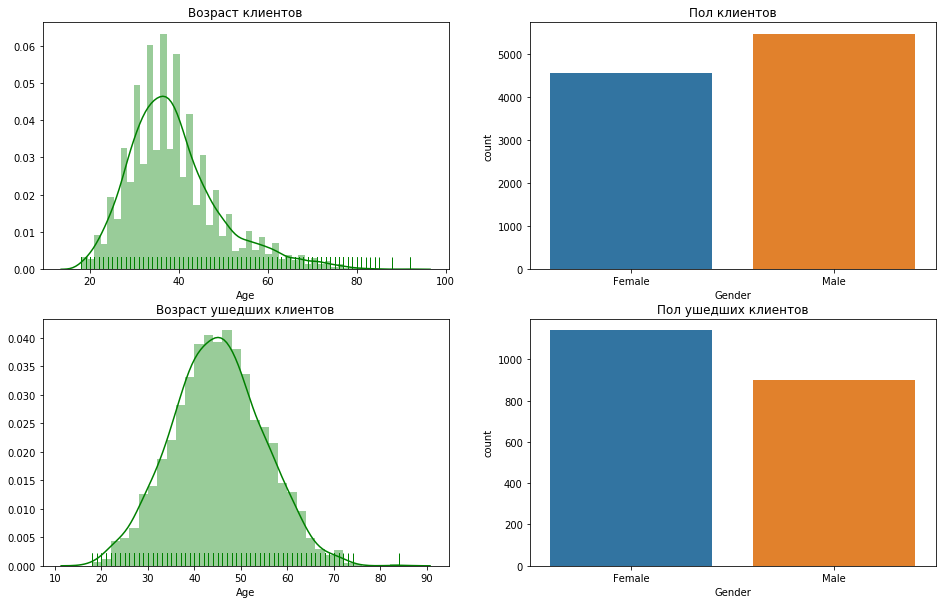

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))

sns.distplot(data['Age'], ax = axes[0,0], rug=True, color='g')
axes[0,0].set_title('Возраст клиентов')
sns.countplot(x = 'Gender', ax = axes[0,1], data = data)
axes[0,1].set_title('Пол клиентов')
sns.distplot(exited['Age'], ax = axes[1,0], rug=True, color='g')
axes[1,0].set_title('Возраст ушедших клиентов')
sns.countplot(x = 'Gender', ax = axes[1,1], data = exited)
axes[1,1].set_title('Пол ушедших клиентов')
plt.show()

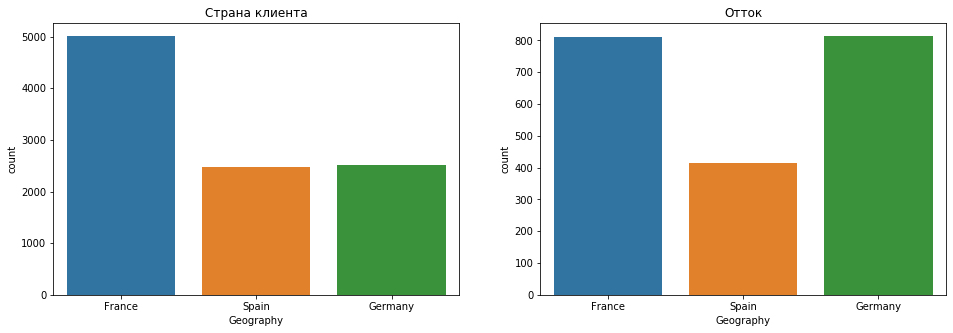

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(ax = axes[0], x='Geography', data = data)
axes[0].set_title("Страна клиента")
sns.countplot(ax = axes[1], x='Geography', data = exited)
axes[1].set_title("Отток")
plt.show()

> За рассмотренный период около 20% клиентов покинули банк, из них наибольшее количество клинетов ушло из Франции и Германии (по 800). При этом клиентов из Германии в банке было в два раза меньше, чем клиентов из Франции. Ушедщих немецких клиентов - 32%. Также банк чаще всего покидали женщины, при том что их среди общего числа клинетов также было меньше. Среди ушедших клиентов гораздо чаще встречаются люди старше среднего возраста клиентов. 

### Подготовка признаков

Для обучения модели нужно заменить категориальные признакие (пол и страна) на количественные. Так как для обучения будут использоваться не только модели деревьев, но и логистическая регрессия, воспользуемся универсальным кодированием: One Hot Encoding. А также удалим неважные для прогнозирвоания признаки, такие как фамилия клиента, его ID и номер строки.

In [10]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1) # удалим признаки, не влияющие на исход
gender = pd.get_dummies(data['Gender'], drop_first=True)        # кодирование пола
geography = pd.get_dummies(data['Geography'], drop_first=True)  # кодирование стран
data = pd.concat([data, gender], axis=1)
data = pd.concat([data, geography], axis=1)
data = data.drop(['Gender', 'Geography'], axis=1)

> Все категориальные признаки мы заменили количесвтенными с помощью прямого кодирования (One Hot Encoding). Для признаков Gender и Geography были созданы столбцы со значениями 0/1 и 0/1/2. 

### Обучение моделей

На данных обучим три модели:
- Логистическая регрессия;
- Дерево решений;
- Случайный лес;   

Выделим в данных признаки и объекты, а также разделим выборки на обучающую, валидационную и тестовую:

In [11]:
features = data.drop('Exited', axis=1)
target = data['Exited']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.2, random_state=12345)

Функция для подсчета метрик модели:

In [12]:
def model_score(model):
    preds = model.predict(features_valid)
    acc = accuracy_score(target_valid, preds)
    model_score.f1 = f1_score(target_valid, preds)
    recall = recall_score(target_valid, preds)
    precision = precision_score(target_valid, preds)
    roc_auc = roc_auc_score(target_valid, preds)
    f1 = f1_score(target_valid, preds)
    print('Правильность: {}'.format(acc))
    print('F1: {}'.format(f1))
    print('Полнота: {}'.format(recall))
    print('Точность: {}'.format(precision))
    print('ROC-AUC: {}'.format(roc_auc))
    return acc, f1, recall, precision, roc_auc

#### Logistic Regression

Для того чтобы обучить модель логистической регресси, масштабируем признаки методом StandardScaler:

In [13]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)

In [14]:
model = LogisticRegression(random_state=12345)
model.fit(features_train_scaled, target_train)
preds = model.predict(features_valid_scaled)
model_score(model);

Правильность: 0.19
F1: 0.31861198738170343
Полнота: 1.0
Точность: 0.1894934333958724
ROC-AUC: 0.5003855050115651


#### Decision Tree

In [15]:
def depth_search(features_train, target_train, features_valid, target_valid): #функция для поиска оптимальной глубины дерева
    best_model = None
    best_f1 = 0
    for depth in range(1,50):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(features_train, target_train)
        preds_tree = model.predict(features_valid)
        f1 = f1_score(target_valid, preds_tree)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
    depth_search.preds_tree = best_model.predict(features_valid)
    print('Число уровней: {}'.format(best_model.max_depth))
    return model_score(best_model), best_model.max_depth

In [16]:
depth_search(features_train, target_train, features_valid, target_valid);

Число уровней: 5
Правильность: 0.858125
F1: 0.5642994241842609
Полнота: 0.48514851485148514
Точность: 0.6743119266055045
ROC-AUC: 0.7152034016046168


#### Random Forest

In [17]:
best_model = None
best_acc = 0

for est in range(1,70):
    model = RandomForestClassifier(random_state = 12345, max_depth=6, n_estimators=est)
    model.fit(features_train, target_train)
    acc = model.score(features_valid, target_valid)
    if acc > best_acc:
        best_acc = acc
        best_model = model
    
print('Глубина дерева:', best_model.max_depth, 'Число деревьев:', best_model.n_estimators)

Глубина дерева: 6 Число деревьев: 62


In [18]:
best_model = None
best_f1 = 0

for depth in range(1,50):
    model = RandomForestClassifier(random_state = 12345, max_depth=depth, n_estimators=9)
    model.fit(features_train, target_train)
    preds = model.predict(features_valid)
    f1 = f1_score(target_valid, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

preds_forest = best_model.predict(features_valid)
model_score(best_model);
print('Глубина дерева:', best_model.max_depth, 'Число деревьев:', best_model.n_estimators)
model_simple = best_model

Правильность: 0.865625
F1: 0.5792563600782779
Полнота: 0.4884488448844885
Точность: 0.7115384615384616
ROC-AUC: 0.7210941217483352
Глубина дерева: 15 Число деревьев: 9


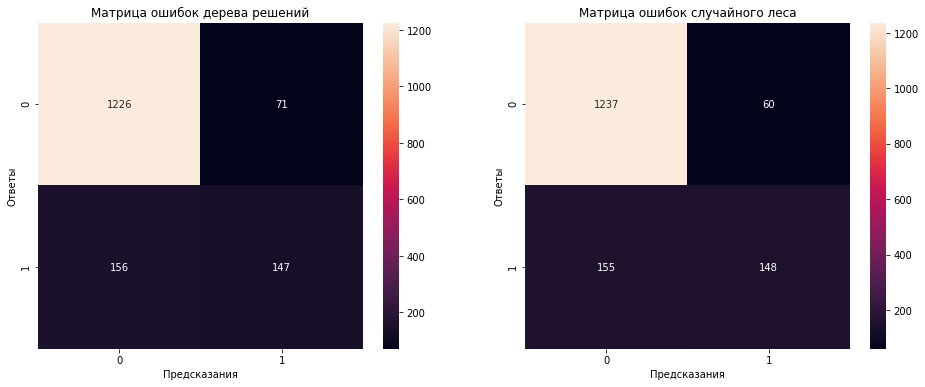

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))

ConfusionMatrixTree = confusion_matrix(target_valid, depth_search.preds_tree)
sns.heatmap(ConfusionMatrixTree, ax = axes[0], annot=True, fmt='d')
axes[0].set(xlabel='Предсказания', ylabel="Ответы")
axes[0].set_title('Матрица ошибок дерева решений')
ConfusionMatrixForest = confusion_matrix(target_valid, preds_forest)
sns.heatmap(ConfusionMatrixForest, ax = axes[1], annot=True, fmt='d')
axes[1].set(xlabel='Предсказания', ylabel="Ответы")
axes[1].set_title('Матрица ошибок случайного леса')

plt.show()

Обе модели можно назвать оптимистичными: чаще всего они ошибаются, когда предсказывают, что человек останется. Дерево решений угадывает только 49% ушедших клиентов, а модель случайного леса - 50%.

In [20]:
columns = ['Model', 'Accuracy', 'F1', 'AUC']
score = {
    'Model' : ['Logistic Regression', 'Decision Tree', 'Random Forest'], 
    'Accuracy': [0.19, 0.85, 0.86],
    'F1': [0.31, 0.56, 0.58],
    'AUC': [0.5, 0.71, 0.72]
}
metrics = pd.DataFrame(score, columns = columns).set_index('Model')
metrics

,Accuracy,F1,AUC
Model,,,
Logistic Regression,0.19,0.31,0.50
Decision Tree,0.85,0.56,0.71
Random Forest,0.86,0.58,0.72


> `Логистическая регрессия`: показатель f1 очень низок, следовательно, модель редко предсказывает исход о том, что клиент уйдет. Низкая правильность говорит, что модель редко предсказывает исход праивльно в любом случае.  
`Дерево решений`: все показатели (правильность, точность и полнота) гораздо выше, чем у результатов модели логистической регрессии. F1 метрика выше 0,5.    
`Случайный лес`: Правильность и метрика f1 выше, чем у дерева решений - скорее всего, данная модель даст лучшие показатели после балансировки выборок.

<a id='section3'></a>
# 3. Борьба с дисбалансом

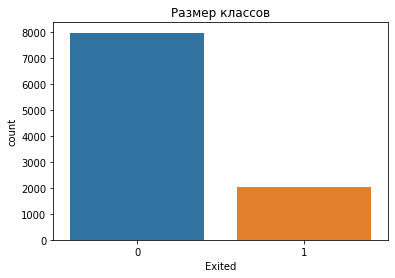

Доля класса 0: 0.7963
Доля класса 1: 0.2037


In [21]:
sns.countplot(x='Exited', data=data).set_title('Размер классов')
plt.show() 

print("Доля класса 0:", len(remain)/len(data))
print("Доля класса 1:", len(exited)/len(data))

> В данных не соблюдается баланс классов: информации об ушедших клиентов гораздо меньше, чем об оставшихся. Для того чтобы модель смогла замечать недовольных клиентов, нужно изменить данные: или уменьшить число оставшихся клиентов, или дублировать количество ушедших.

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

### Decision Tree 

#### Upsampling

In [24]:
best_f1 = 0
best_model = None
best_repeat = 1
for repeat in range(2, 8):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    for depth in range(1,36):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        preds = model.predict(features_valid)
        f1 = f1_score(target_valid, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_repeat = repeat

model_score(best_model);          
print('Глубина дерева = {}, Repeat: {:.2f} '.format(best_model.max_depth, best_repeat))

Правильность: 0.8125
F1: 0.5738636363636364
Полнота: 0.6666666666666666
Точность: 0.5037406483790524
ROC-AUC: 0.7566178360318684
Глубина дерева = 8, Repeat: 3.00 


#### Downsampling

In [25]:
best_f1 = 0
best_model = None
best_fraction = 0.3
for fraction in np.arange(0.3, 0.7, 0.02):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    for depth in range(1,36):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        preds = model.predict(features_valid)
        f1 = f1_score(target_valid, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_fraction = fraction

model_score(best_model);          
print('Глубина дерева = {}, Fraction: {:.2f} '.format(best_model.max_depth, best_fraction))

Правильность: 0.845625
F1: 0.5820642978003384
Полнота: 0.5676567656765676
Точность: 0.5972222222222222
ROC-AUC: 0.7391098014967263
Глубина дерева = 5, Fraction: 0.56 


### Random Forest 

#### Upsampling

In [26]:
best_model = None
best_f1 = 0
for repeat in range(2,8):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    for est in range(1,15):
        for depth in range(1,10):
            model = RandomForestClassifier(random_state = 12345, max_depth=depth, n_estimators=est)
            model.fit(features_upsampled, target_upsampled)
            preds = model.predict(features_valid)
            f1 = f1_score(target_valid, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_repeat = repeat

print('Глубина дерева:', best_model.max_depth, 'Число деревьев:', best_model.n_estimators)
print('Repeat:', best_repeat)

Глубина дерева: 9 Число деревьев: 12
Repeat: 2


In [27]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)
best_model = None
best_f1 = 0
for est in range(2,35):
        for depth in range(5,30):
            model = RandomForestClassifier(random_state = 12345, max_depth=depth, n_estimators=est)
            model.fit(features_upsampled, target_upsampled)
            preds = model.predict(features_valid)
            f1 = f1_score(target_valid, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
preds_forest_up = best_model.predict(features_valid)
model_score(best_model);
model_up = best_model

Правильность: 0.870625
F1: 0.6243194192377496
Полнота: 0.5676567656765676
Точность: 0.6935483870967742
ROC-AUC: 0.7545300019593324


#### Downsampling

Найдем лучшую долю для нулевого класса, используя в цикле небольшие значения для параметров глубины дерева и количества деревьев:

In [28]:
best_model = None
best_f1 = 0
for fraction in np.arange(0.2, 0.86, 0.2):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    for depth in range(2, 10):
        for est in range(1,10):
            model = RandomForestClassifier(random_state = 12345, max_depth=depth, n_estimators=est)
            model.fit(features_downsampled, target_downsampled)
            preds = model.predict(features_valid)
            f1 = f1_score(target_valid, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                fraction_best = fraction
        
        
preds_forest_down = best_model.predict(features_valid)
f1 = f1_score(target_valid, preds_forest_down)
print('F1 мера:', f1)
print('Доля класса 0:', fraction_best)

F1 мера: 0.5971731448763251
Доля класса 0: 0.6000000000000001


In [29]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)
best_model = None
best_f1 = 0
for depth in range(2, 20):
    for est in range(15,36):
        model = RandomForestClassifier(random_state = 12345, max_depth=depth, n_estimators=est)
        model.fit(features_downsampled, target_downsampled)
        preds = model.predict(features_valid)
        f1 = f1_score(target_valid, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            fraction_best = fraction
            
preds_forest_down = best_model.predict(features_valid)            
model_score(best_model);        
print('Глубина дерева:', best_model.max_depth, 'Число деревьев:', best_model.n_estimators)
model_down = best_model

Правильность: 0.836875
F1: 0.6098654708520179
Полнота: 0.6732673267326733
Точность: 0.5573770491803278
ROC-AUC: 0.7741818514927823
Глубина дерева: 14 Число деревьев: 28


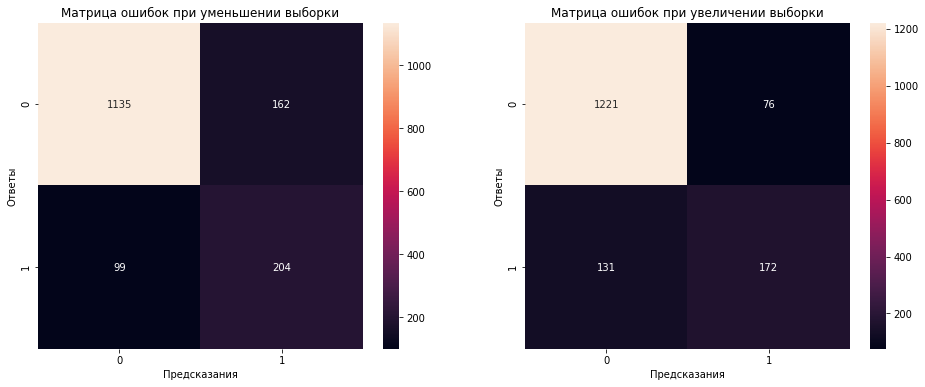

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))

ConfusionMatrixTree = confusion_matrix(target_valid,  preds_forest_down)
sns.heatmap(ConfusionMatrixTree, ax = axes[0], annot=True, fmt='d')
axes[0].set(xlabel='Предсказания', ylabel="Ответы")
axes[0].set_title('Матрица ошибок при уменьшении выборки')
ConfusionMatrixForest = confusion_matrix(target_valid, preds_forest_up)
sns.heatmap(ConfusionMatrixForest, ax = axes[1], annot=True, fmt='d')
axes[1].set(xlabel='Предсказания', ylabel="Ответы")
axes[1].set_title('Матрица ошибок при увеличении выборки')

plt.show()

Балансировка выборок различными методами дает примерно одинаковый результат в предсказании ушедших клиентов, их метрика F1  равна 0,61 в обоих случаях. Однако на матрице ошибок видно, что в случае уменьшения выборки класса 0 классификатор все же ошибается реже.

In [31]:
columns = ['Model', 'Accuracy', 'F1', 'AUC']
score = {
    'Model' : ['Decision Tree Upsampled', 'Random Forest Upsampled', 'Decision Tree Downsampled', 'Random Forest Downsampled'],
    'Accuracy': [0.83, 0.86, 0.84, 0.86],
    'F1': [0.57, 0.61, 0.58, 0.61],
    'AUC': [0.73, 0.75, 0.73, 0.75]
}
metrics = pd.DataFrame(score, columns = columns).set_index('Model')
metrics

,Accuracy,F1,AUC
Model,,,
Decision Tree Upsampled,0.83,0.57,0.73
Random Forest Upsampled,0.86,0.61,0.75
Decision Tree Downsampled,0.84,0.58,0.73
Random Forest Downsampled,0.86,0.61,0.75


### AUC-ROC

Визуализируем результат работы алгоритма случайного леса с помощью кривой ошибок:

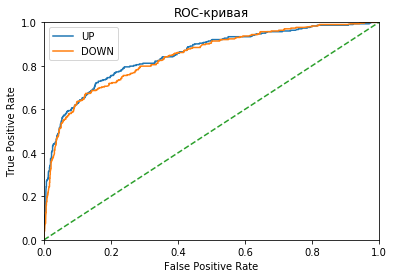

In [32]:
probabilities_valid_up = model_up.predict_proba(features_valid)
probabilities_one_valid_up = probabilities_valid_up[:, 1]

probabilities_valid_down = model_down.predict_proba(features_valid)
probabilities_one_valid_down = probabilities_valid_down[:, 1]

fpr1, tpr1, thresholds = roc_curve(target_valid, probabilities_one_valid_up) 
fpr2, tpr2, thresholds = roc_curve(target_valid, probabilities_one_valid_down)
plt.figure()

plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.legend(['UP', 'DOWN'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Метрика AUC лучше, чем у случайной модели. Оптимальное пороговое значение для кривых будет равно приблизительно 0,75 (0,75 для True Positive и 0.2 для False Positive).

<a id='section4'></a>
# 4. Тестирование модели

In [33]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)
model = RandomForestClassifier(random_state=12345, max_depth=7, n_estimators=24)
model.fit(features_downsampled, target_downsampled)
preds = model.predict(features_test)
print('Правильность: {}'.format(accuracy_score(target_test, preds)))
print('F1: {}'.format(f1_score(target_test, preds)))
print('Полнота: {}'.format(recall_score(target_test, preds)))
print('Точность: {}'.format(precision_score(target_test, preds)))
print('ROC-AUC: {}'.format(roc_auc_score(target_test, preds)))

Правильность: 0.8435
F1: 0.6389850057670127
Полнота: 0.6487119437939111
Точность: 0.6295454545454545
ROC-AUC: 0.7725441473578583


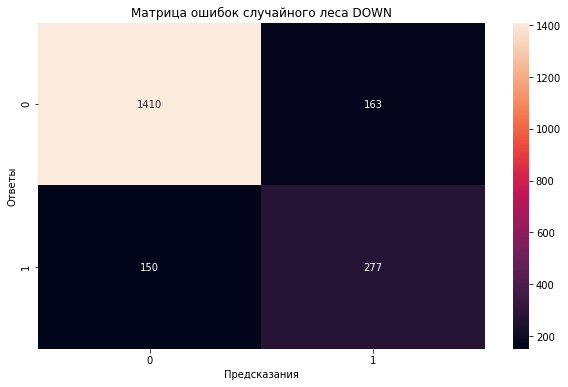

In [34]:
plt.figure(figsize=(10,6))
ConfusionMatrixForestDown = confusion_matrix(target_test, preds)
matrix = sns.heatmap(ConfusionMatrixForestDown, annot=True, fmt='d')
matrix.set(xlabel='Предсказания', ylabel="Ответы")
matrix.set_title('Матрица ошибок случайного леса DOWN')
plt.show()

В проекте создавался классификатор для распознования недовольных клиентов банка. Для прогнозирования были применены три модели: логистическая регрессия, дерево решений и случайный лес. Так как данные были несбалансированны, существовала проблема выделения меньшего класса. На несбалансированных данных лучше всего работала модель случайного леса. После балансировки её метрика F1 увеличилась с 0.589 до 0.61. На тестовой выборке данная модель показывает f1 0.636. Для балансировки в данном случае использовалось уменьшение большей выборки на 60%.